# Mid-term Peak Demand Prediction
# SARIMA and STL-LSTM models were used

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Import packages
import pandas as pd
import numpy as np
import itertools
from statsmodels.tsa.seasonal import seasonal_decompose
import math
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, KFold, TimeSeriesSplit, GridSearchCV
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression as LR
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from pmdarima import auto_arima, ARIMA
from pmdarima.model_selection import SlidingWindowForecastCV
from pmdarima.model_selection import cross_val_score as SARIMACV

from xgboost import XGBRegressor as XGB

from cycler import cycler
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
import keras
tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
from keras.layers import Bidirectional
import time as t
from keras.layers import Dropout

from statsmodels.tsa.seasonal import STL


Device mapping: no known devices.


## Step 1: Load Dataset

In [2]:
# Load dataset
data = pd.read_csv("ContinuousDataset.csv")
# Visualize first five rows in the data
data.head()

,datetime,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
0,1/3/2015 1:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0,0,0
1,1/3/2015 2:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0,0,0
2,1/3/2015 3:00,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,0.016479,0.078735,5.871184,0,0,0
3,1/3/2015 4:00,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,0.016487,0.068390,5.883621,0,0,0
4,1/3/2015 5:00,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,0.016456,0.064362,5.611724,0,0,0


## Step 2: Dataset Preparation and Pre-Processing

In [3]:
# Create DataFrame
df = pd.DataFrame(data)
# Drop hour column
df[['datetime','hour']] = df['datetime'].str.split(' ',expand=True)
df = df.drop(['hour'], axis='columns')
#df = df.drop(['hour', 'T2M_toc', 'QV2M_toc', 'TQL_toc', 'W2M_toc', 'T2M_san', 'QV2M_san', 'TQL_san',
#              'W2M_san', 'T2M_dav', 'QV2M_dav', 'TQL_dav', 'W2M_dav', 'Holiday_ID', 'holiday', 'school'], axis='columns')
# Visualize first five rows in the updated data
df.head()

,datetime,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
0,1/3/2015,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0,0,0
1,1/3/2015,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0,0,0
2,1/3/2015,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,0.016479,0.078735,5.871184,0,0,0
3,1/3/2015,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,0.016487,0.068390,5.883621,0,0,0
4,1/3/2015,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,0.016456,0.064362,5.611724,0,0,0


In [4]:
df = df.loc[df.groupby('datetime')['nat_demand'].idxmax()].sort_index()
df.head()

,datetime,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
9,1/3/2015,1257.5069,29.766656,0.018759,0.009018,25.862671,29.172906,0.018675,0.004921,15.081688,26.704156,0.016608,0.058685,4.685580,0,0,0
42,1/4/2015,1137.1754,26.265131,0.017882,0.004063,21.902019,25.499506,0.017768,0.035980,11.164779,23.460443,0.016951,0.114410,5.833417,0,0,0
60,1/5/2015,1430.5514,30.220422,0.017515,0.005730,31.021351,30.157922,0.017858,0.034668,19.023205,27.251672,0.016325,0.111603,7.372792,0,0,0
84,1/6/2015,1437.4700,30.376520,0.017278,0.000972,28.283986,30.142145,0.017743,0.016373,16.887316,27.298395,0.016408,0.077423,6.105607,0,0,0
109,1/7/2015,1408.6819,29.552118,0.017134,0.015839,29.857418,29.755243,0.017356,0.029648,17.731607,26.536493,0.015444,0.102631,7.307453,0,0,0


In [5]:
df[['month','day','year']] = df['datetime'].str.split('/',expand=True)
df = df.drop(['datetime'], axis='columns')
df.head()

,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school,month,day,year
9,1257.5069,29.766656,0.018759,0.009018,25.862671,29.172906,0.018675,0.004921,15.081688,26.704156,0.016608,0.058685,4.685580,0,0,0,1,3,2015
42,1137.1754,26.265131,0.017882,0.004063,21.902019,25.499506,0.017768,0.035980,11.164779,23.460443,0.016951,0.114410,5.833417,0,0,0,1,4,2015
60,1430.5514,30.220422,0.017515,0.005730,31.021351,30.157922,0.017858,0.034668,19.023205,27.251672,0.016325,0.111603,7.372792,0,0,0,1,5,2015
84,1437.4700,30.376520,0.017278,0.000972,28.283986,30.142145,0.017743,0.016373,16.887316,27.298395,0.016408,0.077423,6.105607,0,0,0,1,6,2015
109,1408.6819,29.552118,0.017134,0.015839,29.857418,29.755243,0.017356,0.029648,17.731607,26.536493,0.015444,0.102631,7.307453,0,0,0,1,7,2015


In [6]:
# Create Date column
cols=["year","month","day"]
df['Date'] = df[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")
df['Date']=pd.to_datetime(df['Date'])
df.head()

,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school,month,day,year,Date
9,1257.5069,29.766656,0.018759,0.009018,25.862671,29.172906,0.018675,0.004921,15.081688,26.704156,0.016608,0.058685,4.685580,0,0,0,1,3,2015,2015-01-03
42,1137.1754,26.265131,0.017882,0.004063,21.902019,25.499506,0.017768,0.035980,11.164779,23.460443,0.016951,0.114410,5.833417,0,0,0,1,4,2015,2015-01-04
60,1430.5514,30.220422,0.017515,0.005730,31.021351,30.157922,0.017858,0.034668,19.023205,27.251672,0.016325,0.111603,7.372792,0,0,0,1,5,2015,2015-01-05
84,1437.4700,30.376520,0.017278,0.000972,28.283986,30.142145,0.017743,0.016373,16.887316,27.298395,0.016408,0.077423,6.105607,0,0,0,1,6,2015,2015-01-06
109,1408.6819,29.552118,0.017134,0.015839,29.857418,29.755243,0.017356,0.029648,17.731607,26.536493,0.015444,0.102631,7.307453,0,0,0,1,7,2015,2015-01-07


In [7]:
# Demand from Jan 2015 to end of 2018
mask = (df['Date'] >= '2015-01-03') & (df['Date'] <= '2019-01-03')
df = df.loc[mask]

In [8]:
df

,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school,month,day,year,Date
9,1257.5069,29.766656,0.018759,0.009018,25.862671,29.172906,0.018675,0.004921,15.081688,26.704156,0.016608,0.058685,4.685580,0,0,0,1,3,2015,2015-01-03
42,1137.1754,26.265131,0.017882,0.004063,21.902019,25.499506,0.017768,0.035980,11.164779,23.460443,0.016951,0.114410,5.833417,0,0,0,1,4,2015,2015-01-04
60,1430.5514,30.220422,0.017515,0.005730,31.021351,30.157922,0.017858,0.034668,19.023205,27.251672,0.016325,0.111603,7.372792,0,0,0,1,5,2015,2015-01-05
84,1437.4700,30.376520,0.017278,0.000972,28.283986,30.142145,0.017743,0.016373,16.887316,27.298395,0.016408,0.077423,6.105607,0,0,0,1,6,2015,2015-01-06
109,1408.6819,29.552118,0.017134,0.015839,29.857418,29.755243,0.017356,0.029648,17.731607,26.536493,0.015444,0.102631,7.307453,0,0,0,1,7,2015,2015-01-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34986,1248.7756,25.943842,0.017516,0.004276,18.609584,24.264154,0.016608,0.007729,9.369202,23.201654,0.016036,0.045685,5.363840,0,0,0,12,30,2018,2018-12-30
35002,1288.1942,29.251917,0.017701,0.001066,24.439447,29.142542,0.017144,0.002816,17.128650,26.548792,0.015088,0.016785,6.712480,22,1,0,12,31,2018,2018-12-31
35035,1148.1311,25.555078,0.017385,0.009068,24.418105,24.703516,0.017492,0.004416,10.727559,23.047266,0.016500,0.072906,6.004097,1,1,0,1,1,2019,2019-01-01
35053,1523.8618,29.928369,0.017694,0.081238,20.467294,30.045557,0.017633,0.006001,14.609604,27.201807,0.015817,0.035187,4.860246,0,0,0,1,2,2019,2019-01-02


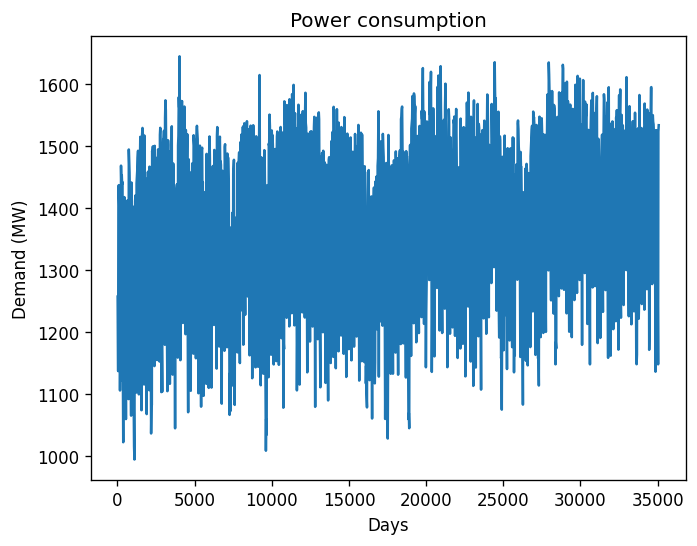

In [9]:
# Plot data for visualization
figure, ax = plt.subplots(dpi=120)
df.reset_index().plot(x = 'index', y = 'nat_demand', style = '-', legend = None, ax = ax)
plt.title('Power consumption')
plt.xlabel('Days')
plt.ylabel('Demand (MW)')
plt.show()

In [10]:
# Obtain Trend, Seasonality, and error features
df.set_index('Date', inplace=True)
#analyze = df[['Quantity']].copy()
analyze = df[['nat_demand']].copy()
decomposed_data = seasonal_decompose(analyze)

Text(0.5, 0, 'Date')

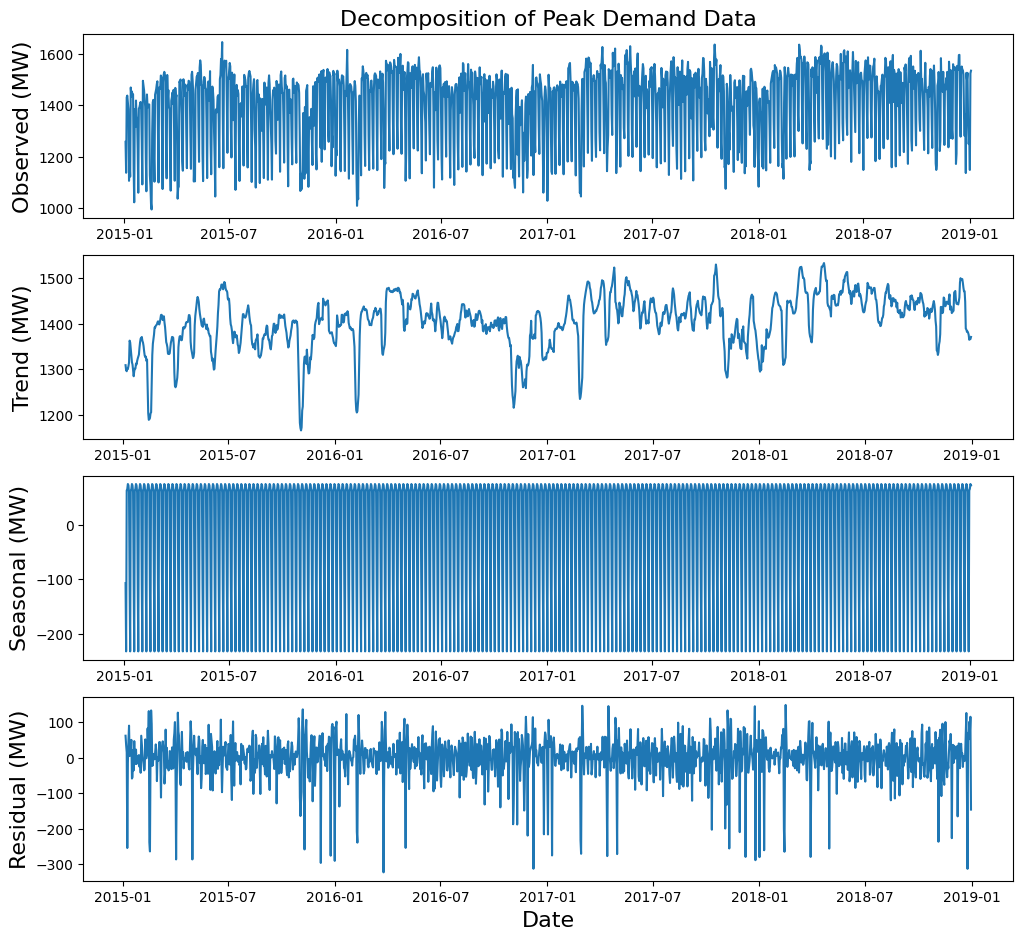

In [11]:
# Set plot sizes and alignment
fig, ax = plt.subplots(4, 1, figsize=(12,11))

# Plot Observed, trend, seasonality, and residual plots
ax[0].plot(decomposed_data.observed);
ax[1].plot(decomposed_data.trend);
ax[2].plot(decomposed_data.seasonal);
ax[3].plot(decomposed_data.resid);

# Set plot labels
ax[0].set_title('Decomposition of Peak Demand Data', fontsize=16)
ax[0].set_ylabel('Observed (MW)', fontsize=16)
ax[1].set_ylabel('Trend (MW)', fontsize=16)
ax[2].set_ylabel('Seasonal (MW)', fontsize=16)
ax[3].set_ylabel('Residual (MW)', fontsize=16)
ax[3].set_xlabel('Date', fontsize=16)

In [12]:
dates = pd.date_range(start='2015-01-03', end='2019-01-03', freq='D')
df['day'] = [i.day for i in dates]
df['month'] = [i.month for i in dates]
df['year'] = [i.year for i in dates]
df.head()

,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school,month,day,year
Date,,,,,,,,,,,,,,,,,,,
2015-01-03,1257.5069,29.766656,0.018759,0.009018,25.862671,29.172906,0.018675,0.004921,15.081688,26.704156,0.016608,0.058685,4.685580,0,0,0,1,3,2015
2015-01-04,1137.1754,26.265131,0.017882,0.004063,21.902019,25.499506,0.017768,0.035980,11.164779,23.460443,0.016951,0.114410,5.833417,0,0,0,1,4,2015
2015-01-05,1430.5514,30.220422,0.017515,0.005730,31.021351,30.157922,0.017858,0.034668,19.023205,27.251672,0.016325,0.111603,7.372792,0,0,0,1,5,2015
2015-01-06,1437.4700,30.376520,0.017278,0.000972,28.283986,30.142145,0.017743,0.016373,16.887316,27.298395,0.016408,0.077423,6.105607,0,0,0,1,6,2015
2015-01-07,1408.6819,29.552118,0.017134,0.015839,29.857418,29.755243,0.017356,0.029648,17.731607,26.536493,0.015444,0.102631,7.307453,0,0,0,1,7,2015


In [13]:
# Create z-normalization function
def normalizeData(data, mean, std):
    normalized = (data-mean)/(std)
    return normalized

# Create denormalization function
def denormalizeData(normalized_data, mean, std):
    denormalized = (normalized_data*std)+(mean)
    return denormalized

In [14]:
# Split data into inputs and target
X = np.array(df.drop(["nat_demand"],1))
y = np.array(df["nat_demand"])

# Split data into training and test sets
n_train = math.floor(0.94 * X.shape[0]) # 94% training
n_valid = math.floor(0.04 * X.shape[0]) # 4% validation
n_test = math.ceil(0.02 * X.shape[0]) # 2% testing

# Training set 
X_train = X[:n_train]
y_train = y[:n_train]

# Removing Training set, and associating the rest for Validation and test
X = pd.DataFrame(X)
X = X.drop(pd.DataFrame(X_train).index)

y = pd.DataFrame(y)
y = y.drop(pd.DataFrame(y_train).index)

# Validation set
X_valid = X[:n_valid]
y_valid = y[:n_valid]

# Testing set
X_test = X[n_valid:]
y_test = y[n_valid:]


print (f"Train number= {n_train} , Validation number= {n_valid}, Test number= {n_test}")

Train number= 1374 , Validation number= 58, Test number= 30


In [15]:
pd.DataFrame(X_train)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,29.766656,0.018759,0.009018,25.862671,29.172906,0.018675,0.004921,15.081688,26.704156,0.016608,0.058685,4.685580,0.0,0.0,0.0,1.0,3.0,2015.0
1,26.265131,0.017882,0.004063,21.902019,25.499506,0.017768,0.035980,11.164779,23.460443,0.016951,0.114410,5.833417,0.0,0.0,0.0,1.0,4.0,2015.0
2,30.220422,0.017515,0.005730,31.021351,30.157922,0.017858,0.034668,19.023205,27.251672,0.016325,0.111603,7.372792,0.0,0.0,0.0,1.0,5.0,2015.0
3,30.376520,0.017278,0.000972,28.283986,30.142145,0.017743,0.016373,16.887316,27.298395,0.016408,0.077423,6.105607,0.0,0.0,0.0,1.0,6.0,2015.0
4,29.552118,0.017134,0.015839,29.857418,29.755243,0.017356,0.029648,17.731607,26.536493,0.015444,0.102631,7.307453,0.0,0.0,0.0,1.0,7.0,2015.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1369,27.555139,0.019617,0.392578,19.589577,26.820764,0.019151,0.164978,15.263495,24.648889,0.018434,0.354980,6.121356,0.0,0.0,1.0,10.0,3.0,2018.0
1370,28.043542,0.019014,0.219055,23.682665,28.246667,0.018716,0.203186,14.539086,26.199792,0.016809,0.268799,4.628164,0.0,0.0,1.0,10.0,4.0,2018.0
1371,28.153436,0.018359,0.044098,24.893412,27.419061,0.018283,0.187500,16.007345,25.622186,0.017031,0.257324,6.593005,0.0,0.0,1.0,10.0,5.0,2018.0
1372,28.142480,0.018031,0.017570,18.982069,28.173730,0.017474,0.037689,10.708180,26.814355,0.014784,0.009609,4.102592,0.0,0.0,1.0,10.0,6.0,2018.0


In [16]:
pd.DataFrame(X_valid)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
1374,29.281854,0.018473,0.079437,8.584478,29.594354,0.018534,0.153259,9.600924,28.734979,0.015864,0.061218,5.796057,0.0,0.0,1.0,10.0,8.0,2018.0
1375,28.039819,0.018458,0.213135,2.007946,28.539819,0.018924,0.214417,10.147852,27.571069,0.016169,0.041840,4.767101,0.0,0.0,1.0,10.0,9.0,2018.0
1376,27.976587,0.017825,0.183350,5.793832,28.164087,0.018618,0.183716,8.606920,27.070337,0.015521,0.056870,4.446354,0.0,0.0,1.0,10.0,10.0,2018.0
1377,26.960046,0.018839,0.317505,17.105127,26.241296,0.018343,0.382446,15.795119,24.303796,0.017115,0.396851,6.838680,0.0,0.0,1.0,10.0,11.0,2018.0
1378,27.480310,0.018733,0.262207,26.569111,26.433435,0.018054,0.302734,17.365972,25.011560,0.017184,0.413940,7.757218,0.0,0.0,1.0,10.0,12.0,2018.0
1379,27.417688,0.018284,0.204407,27.640266,27.355188,0.018475,0.227112,17.321839,24.605188,0.017292,0.453613,7.691434,0.0,0.0,1.0,10.0,13.0,2018.0
1380,25.787408,0.018589,0.154785,14.565056,24.521783,0.018230,0.219910,8.676082,23.256158,0.017826,0.340576,6.041874,0.0,0.0,1.0,10.0,14.0,2018.0
1381,27.918054,0.018824,0.251587,16.856082,26.730554,0.018488,0.364746,14.898547,23.824304,0.017092,0.391968,6.448371,0.0,0.0,1.0,10.0,15.0,2018.0
1382,28.050623,0.018268,0.129578,10.254947,28.019373,0.018985,0.291504,13.788050,25.534998,0.017574,0.303101,6.912395,0.0,0.0,1.0,10.0,16.0,2018.0
1383,27.545160,0.018155,0.201843,2.978615,26.560785,0.019139,0.285034,9.677086,25.545160,0.017171,0.360718,5.184444,0.0,0.0,1.0,10.0,17.0,2018.0


In [17]:
pd.DataFrame(X_test)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
1432,29.011102,0.017470,0.056534,22.054388,29.386102,0.017226,0.170044,9.250403,26.557977,0.014289,0.106415,2.131749,0.0,0.0,1.0,12.0,5.0,2018.0
1433,29.540460,0.018017,0.138184,21.204110,29.727960,0.017941,0.064758,12.748706,27.649835,0.016438,0.170105,2.165156,0.0,0.0,1.0,12.0,6.0,2018.0
1434,29.617029,0.017998,0.123169,20.784503,30.304529,0.017654,0.007896,8.465836,27.640466,0.015945,0.043304,0.923038,0.0,0.0,1.0,12.0,7.0,2018.0
1435,26.887598,0.018826,0.018082,11.980153,25.629785,0.018132,0.047775,3.263342,23.817285,0.017224,0.173828,1.868430,19.0,1.0,1.0,12.0,8.0,2018.0
1436,26.558923,0.018481,0.002188,15.073932,25.597986,0.018801,0.154175,4.887096,23.629236,0.017481,0.212952,2.478044,0.0,0.0,1.0,12.0,9.0,2018.0
1437,29.496118,0.017785,0.001522,24.046441,30.394556,0.018441,0.021904,12.381379,27.917993,0.016694,0.109070,2.424887,0.0,0.0,1.0,12.0,10.0,2018.0
1438,29.465265,0.017602,0.032364,25.821002,29.824640,0.017724,0.015057,14.151579,27.199640,0.015901,0.086060,4.005343,0.0,0.0,1.0,12.0,11.0,2018.0
1439,29.697351,0.017830,0.034256,24.459177,29.837976,0.017448,0.010078,12.062414,27.533289,0.015598,0.073334,2.466831,0.0,0.0,1.0,12.0,12.0,2018.0
1440,29.989862,0.018509,0.020859,20.610973,30.521112,0.018875,0.059753,7.362206,28.122675,0.016212,0.097046,2.521940,0.0,0.0,1.0,12.0,13.0,2018.0
1441,30.130365,0.019024,0.007614,11.755506,30.724115,0.018940,0.079071,5.849618,28.302240,0.017247,0.118652,5.214427,0.0,0.0,1.0,12.0,14.0,2018.0


In [18]:
# Mean and standard deviation of training set
Xtrain_mean = np.mean(X_train)
Xtrain_std = np.std(X_train)
ytrain_mean = np.mean(y_train)
ytrain_std = np.std(y_train)

In [19]:
# Normalize data
Xtrain_norm = normalizeData(X_train, Xtrain_mean, Xtrain_std)
ytrain_norm = normalizeData(y_train, ytrain_mean, ytrain_std)
Xtest_norm = normalizeData(X_test, Xtrain_mean, Xtrain_std)
ytest_norm = normalizeData(y_test, ytrain_mean, ytrain_std)
Xvalid_norm = normalizeData(X_valid, Xtrain_mean, Xtrain_std)
yvalid_norm = normalizeData(y_valid, ytrain_mean, ytrain_std)


## Step 3: SARIMA Model

In [20]:
# Seperating train set, validation set, and test set for SARIMA model:

trainData = df[:n_train]

# Removing Training set, and associating the rest for Validation and test
ds = pd.DataFrame(df)
ds = ds.drop(pd.DataFrame(trainData).index)

validData = ds[:n_valid]
testData = ds[n_valid:]

In [21]:
trainData

,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school,month,day,year
Date,,,,,,,,,,,,,,,,,,,
2015-01-03,1257.5069,29.766656,0.018759,0.009018,25.862671,29.172906,0.018675,0.004921,15.081688,26.704156,0.016608,0.058685,4.685580,0,0,0,1,3,2015
2015-01-04,1137.1754,26.265131,0.017882,0.004063,21.902019,25.499506,0.017768,0.035980,11.164779,23.460443,0.016951,0.114410,5.833417,0,0,0,1,4,2015
2015-01-05,1430.5514,30.220422,0.017515,0.005730,31.021351,30.157922,0.017858,0.034668,19.023205,27.251672,0.016325,0.111603,7.372792,0,0,0,1,5,2015
2015-01-06,1437.4700,30.376520,0.017278,0.000972,28.283986,30.142145,0.017743,0.016373,16.887316,27.298395,0.016408,0.077423,6.105607,0,0,0,1,6,2015
2015-01-07,1408.6819,29.552118,0.017134,0.015839,29.857418,29.755243,0.017356,0.029648,17.731607,26.536493,0.015444,0.102631,7.307453,0,0,0,1,7,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-10-03,1520.4832,27.555139,0.019617,0.392578,19.589577,26.820764,0.019151,0.164978,15.263495,24.648889,0.018434,0.354980,6.121356,0,0,1,10,3,2018
2018-10-04,1525.5337,28.043542,0.019014,0.219055,23.682665,28.246667,0.018716,0.203186,14.539086,26.199792,0.016809,0.268799,4.628164,0,0,1,10,4,2018
2018-10-05,1467.5810,28.153436,0.018359,0.044098,24.893412,27.419061,0.018283,0.187500,16.007345,25.622186,0.017031,0.257324,6.593005,0,0,1,10,5,2018


In [22]:
validData

,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school,month,day,year
Date,,,,,,,,,,,,,,,,,,,
2018-10-08,1611.8197,29.281854,0.018473,0.079437,8.584478,29.594354,0.018534,0.153259,9.600924,28.734979,0.015864,0.061218,5.796057,0,0,1,10,8,2018
2018-10-09,1494.3385,28.039819,0.018458,0.213135,2.007946,28.539819,0.018924,0.214417,10.147852,27.571069,0.016169,0.041840,4.767101,0,0,1,10,9,2018
2018-10-10,1502.7899,27.976587,0.017825,0.183350,5.793832,28.164087,0.018618,0.183716,8.606920,27.070337,0.015521,0.056870,4.446354,0,0,1,10,10,2018
2018-10-11,1460.1205,26.960046,0.018839,0.317505,17.105127,26.241296,0.018343,0.382446,15.795119,24.303796,0.017115,0.396851,6.838680,0,0,1,10,11,2018
2018-10-12,1421.6564,27.480310,0.018733,0.262207,26.569111,26.433435,0.018054,0.302734,17.365972,25.011560,0.017184,0.413940,7.757218,0,0,1,10,12,2018
2018-10-13,1315.2139,27.417688,0.018284,0.204407,27.640266,27.355188,0.018475,0.227112,17.321839,24.605188,0.017292,0.453613,7.691434,0,0,1,10,13,2018
2018-10-14,1225.7777,25.787408,0.018589,0.154785,14.565056,24.521783,0.018230,0.219910,8.676082,23.256158,0.017826,0.340576,6.041874,0,0,1,10,14,2018
2018-10-15,1489.6579,27.918054,0.018824,0.251587,16.856082,26.730554,0.018488,0.364746,14.898547,23.824304,0.017092,0.391968,6.448371,0,0,1,10,15,2018
2018-10-16,1564.9127,28.050623,0.018268,0.129578,10.254947,28.019373,0.018985,0.291504,13.788050,25.534998,0.017574,0.303101,6.912395,0,0,1,10,16,2018


In [23]:
testData

,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school,month,day,year
Date,,,,,,,,,,,,,,,,,,,
2018-12-05,1548.1652,29.011102,0.017470,0.056534,22.054388,29.386102,0.017226,0.170044,9.250403,26.557977,0.014289,0.106415,2.131749,0,0,1,12,5,2018
2018-12-06,1548.0829,29.540460,0.018017,0.138184,21.204110,29.727960,0.017941,0.064758,12.748706,27.649835,0.016438,0.170105,2.165156,0,0,1,12,6,2018
2018-12-07,1535.6805,29.617029,0.017998,0.123169,20.784503,30.304529,0.017654,0.007896,8.465836,27.640466,0.015945,0.043304,0.923038,0,0,1,12,7,2018
2018-12-08,1171.5097,26.887598,0.018826,0.018082,11.980153,25.629785,0.018132,0.047775,3.263342,23.817285,0.017224,0.173828,1.868430,19,1,1,12,8,2018
2018-12-09,1210.7137,26.558923,0.018481,0.002188,15.073932,25.597986,0.018801,0.154175,4.887096,23.629236,0.017481,0.212952,2.478044,0,0,1,12,9,2018
2018-12-10,1553.0889,29.496118,0.017785,0.001522,24.046441,30.394556,0.018441,0.021904,12.381379,27.917993,0.016694,0.109070,2.424887,0,0,1,12,10,2018
2018-12-11,1540.9471,29.465265,0.017602,0.032364,25.821002,29.824640,0.017724,0.015057,14.151579,27.199640,0.015901,0.086060,4.005343,0,0,1,12,11,2018
2018-12-12,1536.8980,29.697351,0.017830,0.034256,24.459177,29.837976,0.017448,0.010078,12.062414,27.533289,0.015598,0.073334,2.466831,0,0,1,12,12,2018
2018-12-13,1594.9841,29.989862,0.018509,0.020859,20.610973,30.521112,0.018875,0.059753,7.362206,28.122675,0.016212,0.097046,2.521940,0,0,1,12,13,2018


In [24]:
# Normalize data for SARIMA
train_mean = np.mean(trainData)
train_std = np.std(trainData)

trainData_norm = normalizeData(trainData, train_mean, train_std)
validData_norm = normalizeData(validData, train_mean, train_std)
testData_norm = normalizeData(testData, train_mean, train_std)



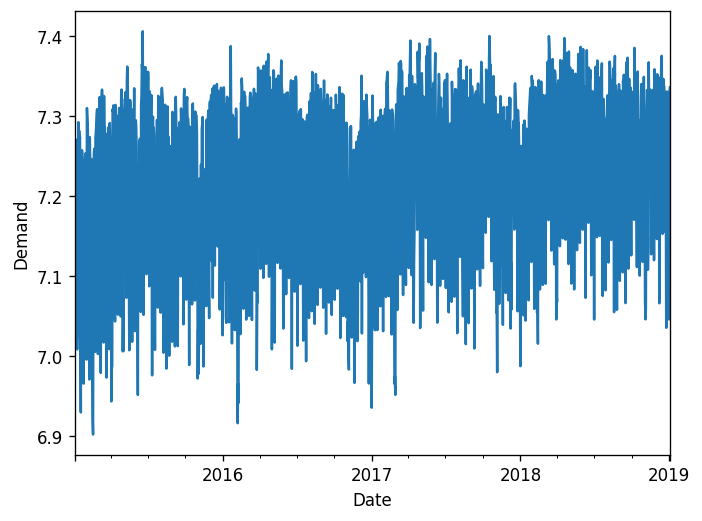

In [25]:
# Plot log10 plot
log_data = np.log(df['nat_demand'])

figure, ax = plt.subplots(dpi=120)
log_data.plot(ax=ax)
plt.ylabel('Demand')
plt.show()

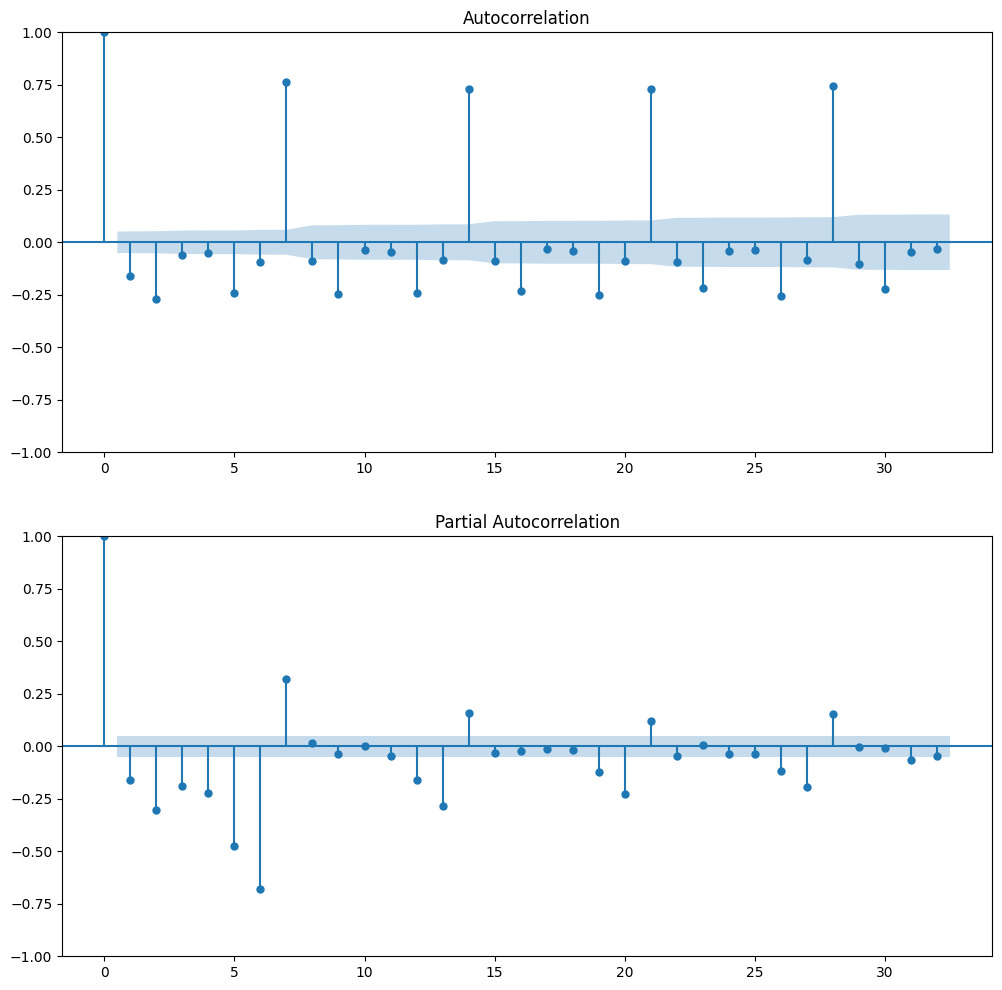

In [26]:
log_data = np.log(df['nat_demand'])
Difflog_data = log_data.diff().dropna()

# Plot ACF and PACF plots
fig, ax = plt.subplots(2, 1, figsize=(12,12))
plot_acf(Difflog_data, ax=ax[0])
plot_pacf(Difflog_data, ax=ax[1])
plt.show()

#### This is cross-validation step for SARIMA

In [27]:
warnings.filterwarnings('ignore')
# K-fold splits for time series
tscv = TimeSeriesSplit(n_splits=5)

# Array to store values
SARIMA_cvscore = []

# Get training set only for Quantity attribute (analyze is previously defined and represents full Quantity column)
analyze = analyze[0:1602]
# Normalize original quantity values
analyze = normalizeData(analyze, ytrain_mean, ytrain_std)

for train_index, test_index in tscv.split(analyze):
    cv_train, cv_test = analyze.iloc[train_index], analyze.iloc[test_index]
    model = SARIMAX(cv_train.nat_demand, order=(1,1,1), seasonal_order=(1,1,1,7)).fit()
    predictions = model.predict(cv_test.index[0], cv_test.index[-1])
    true_values = cv_test.values
    SARIMA_cvscore.append(mean_absolute_percentage_error(true_values, predictions))
    
# MAPE cv-score for all folds
SARIMA_cvscore = np.mean(SARIMA_cvscore)

# Print result
print("Cross-Validation score for SARIMA model is: {:.2f}".format( SARIMA_cvscore))

Cross-Validation score for SARIMA model is: 1.75


In [28]:
warnings.filterwarnings('ignore')

# assigning SARIMA parameters

sarima = SARIMAX(trainData_norm.nat_demand, 
                order=(1,1,1), 
                seasonal_order=(1,1,1,7))

# Fit and predict on training and testing data
SARIMA_fit = sarima.fit(validation_data=(validData_norm.nat_demand))
predictionsTrain = SARIMA_fit.predict(trainData.index[0], trainData.index[-1])
predictionsValid = SARIMA_fit.predict(validData.index[0], validData.index[-1])
predictionsTest = SARIMA_fit.predict(testData.index[0], testData.index[-1])

# Reverse normalization for the training outputs
predictionsTrain = predictionsTrain.to_frame()
predictionsTrain = denormalizeData(predictionsTrain['predicted_mean'].values, train_mean.nat_demand, train_std.nat_demand)

# Reverse normalization for the validation outputs
predictionsValid = predictionsValid.to_frame()
predictionsValid = denormalizeData(predictionsValid['predicted_mean'].values, train_mean.nat_demand, train_std.nat_demand)

# Reverse normalization for the testing outputs
predictionsTest = predictionsTest.to_frame()
predictionsTest = denormalizeData(predictionsTest['predicted_mean'].values, train_mean.nat_demand, train_std.nat_demand)

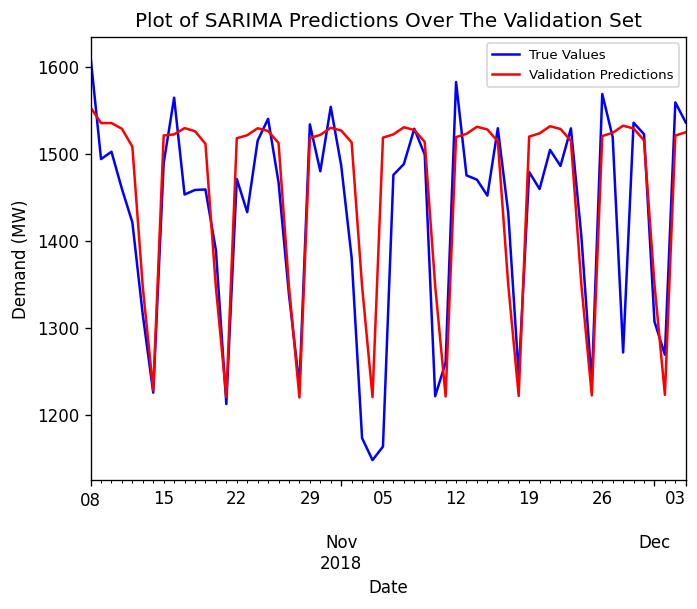

In [29]:
# Plot settings
fig, ax = plt.subplots(dpi=120)
custom_cycler = (cycler(color=['b','r']))
ax.set_prop_cycle(custom_cycler)

# Combine true and predicted values for plotting
predictionsValid = pd.Series(predictionsValid,index=validData.index)
predictionsValid = pd.DataFrame(predictionsValid,index = validData.index,columns=['Validation Predictions'])
pd.concat([validData['nat_demand'], predictionsValid],axis=1).plot(ax=ax)

# Set plot title and labels
plt.title("Plot of SARIMA Predictions Over The Validation Set")
plt.ylabel("Demand (MW)")
Leg = plt.legend(fontsize=8, loc='upper right')
Leg.get_texts()[0].set_text('True Values')

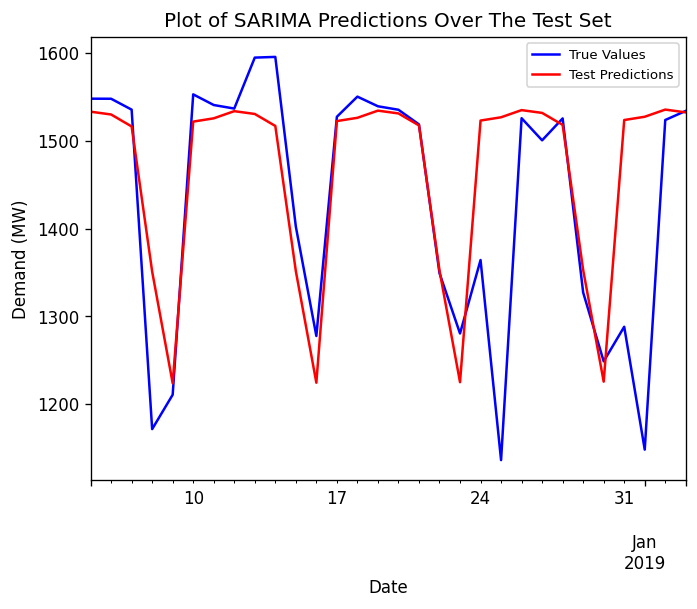

In [30]:
# Plot settings
fig, ax = plt.subplots(dpi=120)
custom_cycler = (cycler(color=['b','r']))
ax.set_prop_cycle(custom_cycler)

# Combine true and predicted values for plotting
predictionsTest = pd.Series(predictionsTest,index=testData.index)
predictionsTest = pd.DataFrame(predictionsTest,index = testData.index,columns=['Test Predictions'])
pd.concat([testData['nat_demand'], predictionsTest],axis=1).plot(ax=ax)

# Set plot title and labels
plt.title("Plot of SARIMA Predictions Over The Test Set")
plt.ylabel("Demand (MW)")
Leg = plt.legend(fontsize=8, loc='upper right')
Leg.get_texts()[0].set_text('True Values')

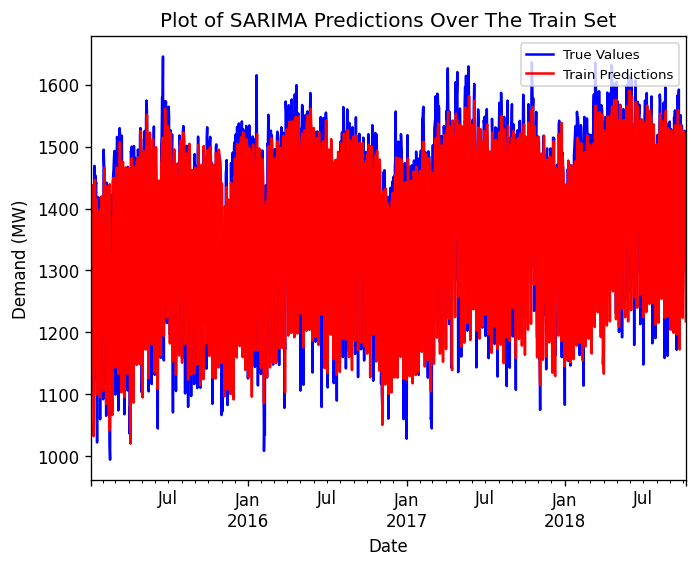

In [31]:
# Plot settings
fig, ax = plt.subplots(dpi=120)
custom_cycler = (cycler(color=['b','r']))
ax.set_prop_cycle(custom_cycler)

# Combine true and predicted values for plotting
predictionsTrain = pd.Series(predictionsTrain,index=trainData.index)
predictionsTrain = pd.DataFrame(predictionsTrain,index = trainData.index,columns=['Train Predictions'])
pd.concat([trainData['nat_demand'], predictionsTrain],axis=1).plot(ax=ax)

# Set plot title and labels
plt.title("Plot of SARIMA Predictions Over The Train Set")
plt.ylabel("Demand (MW)")
Leg = plt.legend(fontsize=8, loc='upper right')
Leg.get_texts()[0].set_text('True Values')

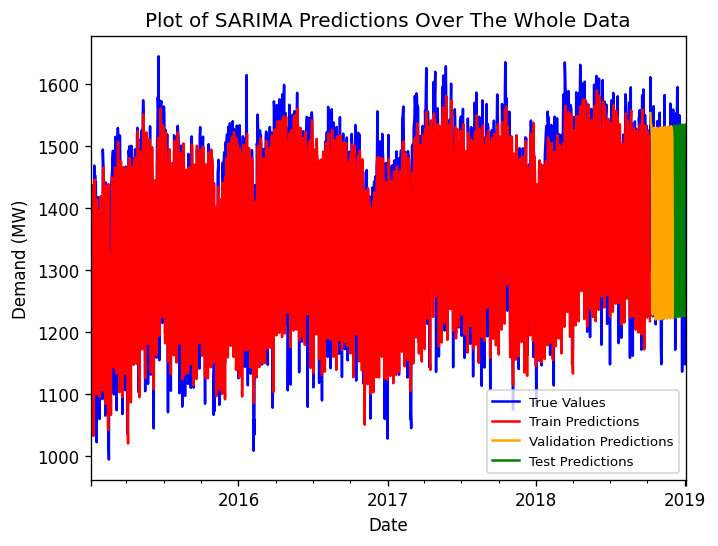

In [32]:
# Plot settings
fig, ax = plt.subplots(dpi=120)
custom_cycler = (cycler(color=['b','r','orange','g']))
ax.set_prop_cycle(custom_cycler)

predictionsAll = pd.concat([predictionsTrain,predictionsValid ,predictionsTest],axis=1)
pd.concat([df['nat_demand'], predictionsAll],axis=1).plot(ax=ax)

# Set plot title and labels
plt.title("Plot of SARIMA Predictions Over The Whole Data")
plt.ylabel("Demand (MW)")
Leg = plt.legend(fontsize=8, loc='lower right')
Leg.get_texts()[0].set_text('True Values')

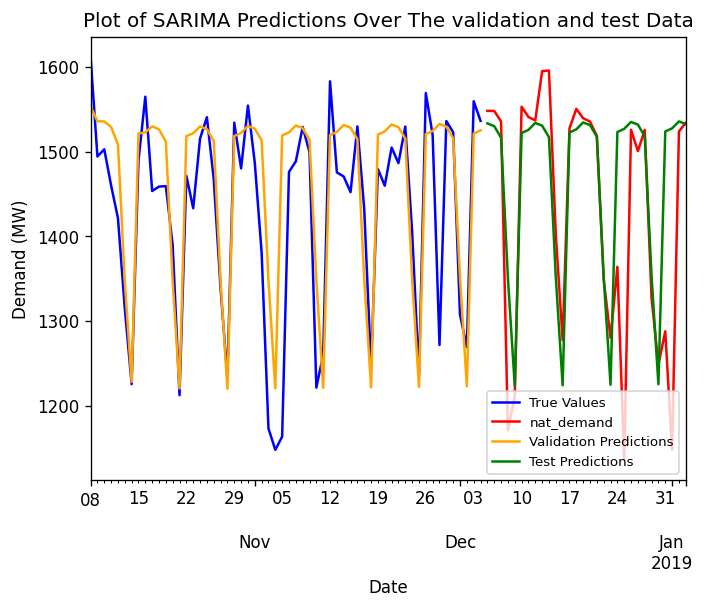

In [33]:
# Plot settings
fig, ax = plt.subplots(dpi=120)
custom_cycler = (cycler(color=['b','r','orange','g']))
ax.set_prop_cycle(custom_cycler)

predictionsAll = pd.concat([predictionsValid ,predictionsTest],axis=1)
trueAll = pd.concat([validData.nat_demand ,testData.nat_demand],axis=1)
pd.concat([trueAll, predictionsAll],axis=1).plot(ax=ax)

validData

# Set plot title and labels
plt.title("Plot of SARIMA Predictions Over The validation and test Data")
plt.ylabel("Demand (MW)")
Leg = plt.legend(fontsize=8, loc='lower right')
Leg.get_texts()[0].set_text('True Values')

In [34]:
# Calculate RMSE
SARIMA_RMSE= math.sqrt(mean_squared_error(testData['nat_demand'].values, predictionsTest['Test Predictions'].values))

# Calculate MAE
SARIMA_MAE= mean_absolute_error(testData['nat_demand'].values, predictionsTest['Test Predictions'].values)

# Calculate MAPE
SARIMA_MAPE = mean_absolute_percentage_error(testData['nat_demand'].values, predictionsTest['Test Predictions'].values)*100

# Print results
print("The Testing RMSE value for the SARIMA model is: {:.2f}".format( SARIMA_RMSE))
print("The Testing MAE value for the SARIMA model is: {:.2f}".format( SARIMA_MAE))
print("The Testing MAPE value for the SARIMA model is: {:.2f}".format( SARIMA_MAPE))

The Testing RMSE value for the SARIMA model is: 120.27
The Testing MAE value for the SARIMA model is: 63.79
The Testing MAPE value for the SARIMA model is: 5.07


# STL-LSTM

In [35]:
# Step 1: Perform STL decomposition on your dataset
stl = STL(trainData['nat_demand'], period=7)
result = stl.fit()
trainData['trend'] = result.trend
trainData['seasonal'] = result.seasonal
trainData['residual'] = result.resid

# Perform STL decomposition on the validation dataset
stl_valid = STL(validData['nat_demand'], period=7)
result_valid = stl_valid.fit()
validData['trend'] = result_valid.trend
validData['seasonal'] = result_valid.seasonal
validData['residual'] = result_valid.resid

# Perform STL decomposition on the test dataset
stl_test = STL(testData['nat_demand'], period=7)
result_test = stl_test.fit()
testData['trend'] = result_test.trend
testData['seasonal'] = result_test.seasonal
testData['residual'] = result_test.resid

In [36]:
# Step 2: Prepare dataset for LSTM
def create_lstm_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
trainData_normalized = scaler.fit_transform(trainData)

# Create the LSTM dataset
look_back = 1
trainX, trainY = create_lstm_dataset(trainData_normalized, look_back)

# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[2]))

# Prepare the validation dataset for LSTM
validData_normalized = scaler.transform(validData)
validX, validY = create_lstm_dataset(validData_normalized, look_back)
validX = np.reshape(validX, (validX.shape[0], 1, validX.shape[2]))

# Prepare the test dataset for LSTM
testData_normalized = scaler.transform(testData)
testX, testY = create_lstm_dataset(testData_normalized, look_back)
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[2]))

In [37]:
# Step 3: Create and train LSTM model

opt= keras.optimizers.Adam(lr=0.001)
model = Sequential()
model.add(LSTM(64, input_shape=(1, trainX.shape[2])))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer=opt)

#model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
history = model.fit(trainX, trainY, epochs=120, batch_size=1, verbose=2, validation_data=(validX, validY))

Epoch 1/120
1372/1372 - 6s - loss: 0.0439 - val_loss: 0.0367 - 6s/epoch - 5ms/step
Epoch 2/120
1372/1372 - 4s - loss: 0.0378 - val_loss: 0.0277 - 4s/epoch - 3ms/step
Epoch 3/120
1372/1372 - 3s - loss: 0.0346 - val_loss: 0.0247 - 3s/epoch - 2ms/step
Epoch 4/120
1372/1372 - 5s - loss: 0.0314 - val_loss: 0.0234 - 5s/epoch - 4ms/step
Epoch 5/120
1372/1372 - 3s - loss: 0.0285 - val_loss: 0.0229 - 3s/epoch - 2ms/step
Epoch 6/120
1372/1372 - 3s - loss: 0.0270 - val_loss: 0.0198 - 3s/epoch - 2ms/step
Epoch 7/120
1372/1372 - 3s - loss: 0.0259 - val_loss: 0.0187 - 3s/epoch - 2ms/step
Epoch 8/120
1372/1372 - 4s - loss: 0.0254 - val_loss: 0.0203 - 4s/epoch - 3ms/step
Epoch 9/120
1372/1372 - 3s - loss: 0.0250 - val_loss: 0.0173 - 3s/epoch - 2ms/step
Epoch 10/120
1372/1372 - 3s - loss: 0.0243 - val_loss: 0.0190 - 3s/epoch - 2ms/step
Epoch 11/120
1372/1372 - 3s - loss: 0.0242 - val_loss: 0.0175 - 3s/epoch - 2ms/step
Epoch 12/120
1372/1372 - 3s - loss: 0.0238 - val_loss: 0.0249 - 3s/epoch - 2ms/step
E

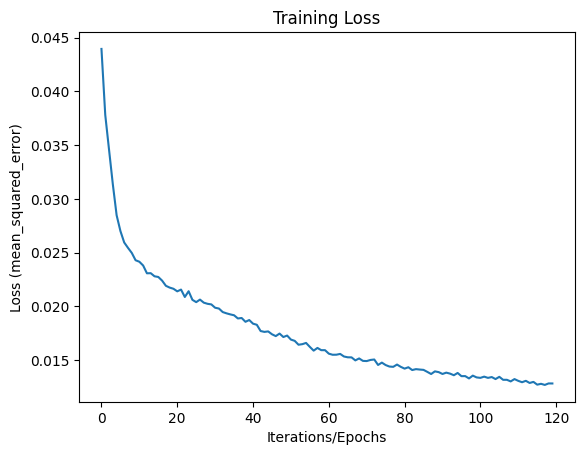

In [38]:
plt.plot(history.history['loss'])
plt.title('Training Loss')
plt.xlabel('Iterations/Epochs')
plt.ylabel('Loss (mean_squared_error)')
plt.show()

In [39]:
# Step 4: Make predictions and evaluate the model
trainPredict = model.predict(trainX)
validPredict = model.predict(validX)
testPredict = model.predict(testX)

# Inverse transform for predicted values
trainPredict_extended = np.zeros((trainPredict.shape[0], trainData_normalized.shape[1]))
trainPredict_extended[:, 0] = trainPredict[:, 0]
trainPredict = scaler.inverse_transform(trainPredict_extended)[:, 0]

validPredict_extended = np.zeros((validPredict.shape[0], validData_normalized.shape[1]))
validPredict_extended[:, 0] = validPredict[:, 0]
validPredict = scaler.inverse_transform(validPredict_extended)[:, 0]

testPredict_extended = np.zeros((testPredict.shape[0], testData_normalized.shape[1]))
testPredict_extended[:, 0] = testPredict[:, 0]
testPredict = scaler.inverse_transform(testPredict_extended)[:, 0]

# Inverse transform for true values
trainY_extended = np.zeros((len(trainY), trainData_normalized.shape[1]))
trainY_extended[:, 0] = trainY
trainY = scaler.inverse_transform(trainY_extended)[:, 0]

validY_extended = np.zeros((len(validY), validData_normalized.shape[1]))
validY_extended[:, 0] = validY
validY = scaler.inverse_transform(validY_extended)[:, 0]

testY_extended = np.zeros((len(testY), testData_normalized.shape[1]))
testY_extended[:, 0] = testY
testY = scaler.inverse_transform(testY_extended)[:, 0]

# Calculate mean absolute error
train_score = mean_absolute_error(trainY, trainPredict)
print('Train Score: %.2f MAE' % (train_score))

valid_score = mean_absolute_error(validY, validPredict)
print('Validation Score: %.2f MAE' % (valid_score))

test_score = mean_absolute_error(testY, testPredict)
print('Test Score: %.2f MAE' % (test_score))

1/1 [==============================] - 0s 30ms/step
Train Score: 53.33 MAE
Validation Score: 57.90 MAE
Test Score: 98.69 MAE


In [40]:
# Calculate RMSE
STL_LSTM_RMSE= math.sqrt(mean_squared_error(testY, testPredict))

# Calculate MAE
STL_LSTM_MAE= mean_absolute_error(testY, testPredict)

# Calculate MAPE
STL_LSTM_MAPE = mean_absolute_percentage_error(testY, testPredict)*100

# Print results
print("The Testing RMSE value for the STL-LSTM model is: {:.2f}".format(STL_LSTM_RMSE))
print("The Testing MAE value for the STL-LSTM model is: {:.2f}".format(STL_LSTM_MAE))
print("The Testing MAPE value for the STL-LSTM model is: {:.2f}".format(STL_LSTM_MAPE))

The Testing RMSE value for the STL-LSTM model is: 140.06
The Testing MAE value for the STL-LSTM model is: 98.69
The Testing MAPE value for the STL-LSTM model is: 7.35


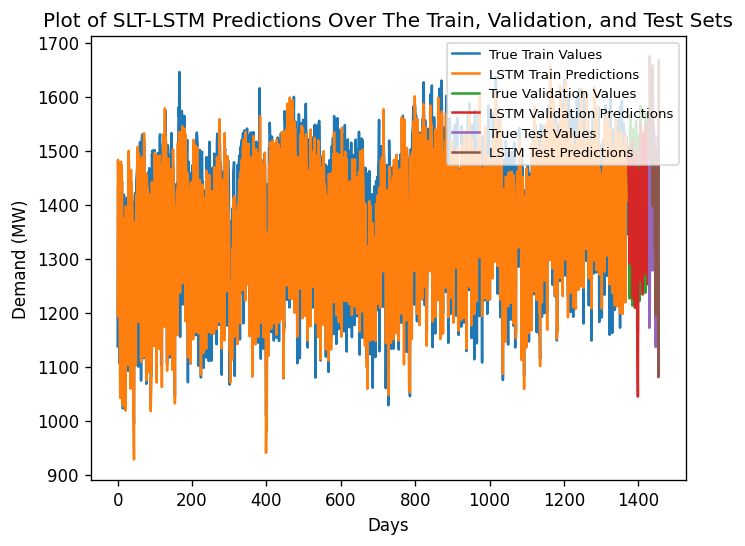

In [41]:
plt.figure(dpi=120)
plt.plot(trainY, label='True Train Values')
plt.plot(trainPredict, label='LSTM Train Predictions')
plt.plot(np.arange(len(trainY), len(trainY) + len(validY)), validY, label='True Validation Values')
plt.plot(np.arange(len(trainY), len(trainY) + len(validY)), validPredict, label='LSTM Validation Predictions')
plt.plot(np.arange(len(trainY) + len(validY), len(trainY) + len(validY) + len(testY)), testY, label='True Test Values')
plt.plot(np.arange(len(trainY) + len(validY), len(trainY) + len(validY) + len(testY)), testPredict, label='LSTM Test Predictions')
plt.title("Plot of SLT-LSTM Predictions Over The Train, Validation, and Test Sets")
plt.ylabel("Demand (MW)")
plt.xlabel("Days")
plt.legend(fontsize=8, loc='upper right')
plt.show()

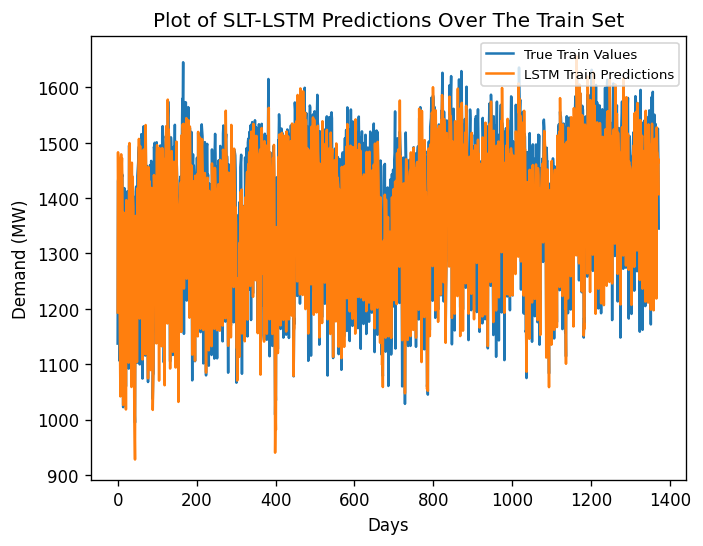

In [42]:
plt.figure(dpi=120)
plt.plot(trainY, label='True Train Values')
plt.plot(trainPredict, label='LSTM Train Predictions')
plt.title("Plot of SLT-LSTM Predictions Over The Train Set")
plt.ylabel("Demand (MW)")
plt.xlabel("Days")
plt.legend(fontsize=8, loc='upper right')
plt.show()

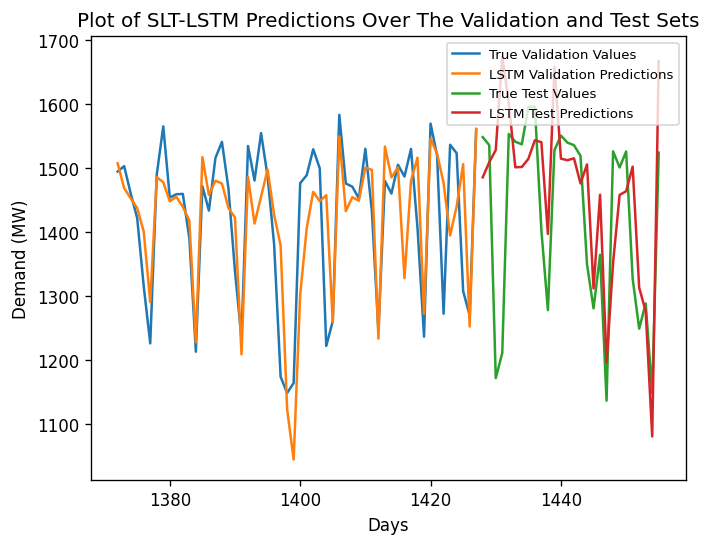

In [43]:
plt.figure(dpi=120)
plt.plot(np.arange(len(trainY), len(trainY) + len(validY)), validY, label='True Validation Values')
plt.plot(np.arange(len(trainY), len(trainY) + len(validY)), validPredict, label='LSTM Validation Predictions')
plt.plot(np.arange(len(trainY) + len(validY), len(trainY) + len(validY) + len(testY)), testY, label='True Test Values')
plt.plot(np.arange(len(trainY) + len(validY), len(trainY) + len(validY) + len(testY)), testPredict, label='LSTM Test Predictions')
plt.title("Plot of SLT-LSTM Predictions Over The Validation and Test Sets")
plt.ylabel("Demand (MW)")
plt.xlabel("Days")
plt.legend(fontsize=8, loc='upper right')
plt.show()

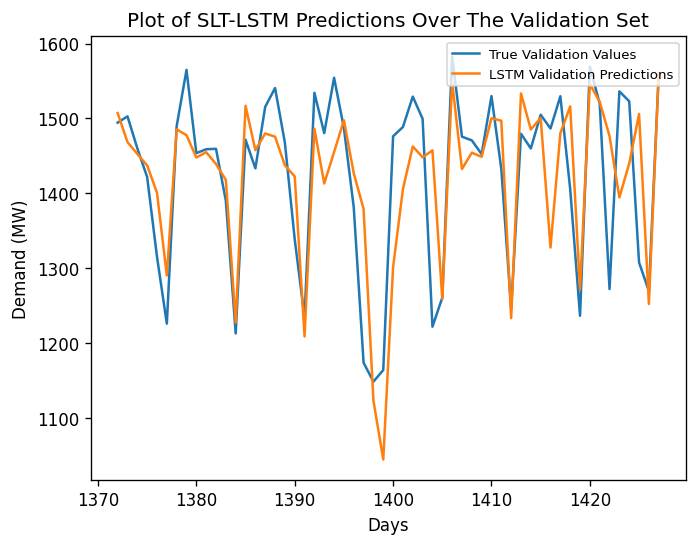

In [44]:
plt.figure(dpi=120)
plt.plot(np.arange(len(trainY), len(trainY) + len(validY)), validY, label='True Validation Values')
plt.plot(np.arange(len(trainY), len(trainY) + len(validY)), validPredict, label='LSTM Validation Predictions')
plt.title("Plot of SLT-LSTM Predictions Over The Validation Set")
plt.ylabel("Demand (MW)")
plt.xlabel("Days")
plt.legend(fontsize=8, loc='upper right')
plt.show()

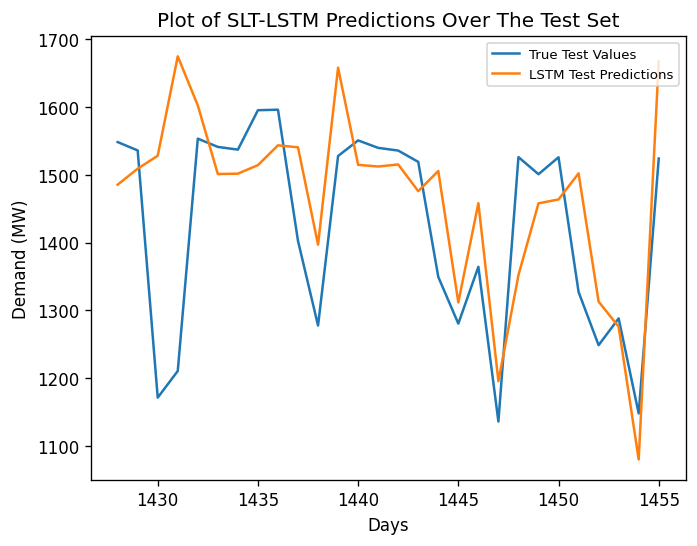

In [45]:
plt.figure(dpi=120)
plt.plot(np.arange(len(trainY) + len(validY), len(trainY) + len(validY) + len(testY)), testY, label='True Test Values')
plt.plot(np.arange(len(trainY) + len(validY), len(trainY) + len(validY) + len(testY)), testPredict, label='LSTM Test Predictions')
plt.title("Plot of SLT-LSTM Predictions Over The Test Set")
plt.ylabel("Demand (MW)")
plt.xlabel("Days")
plt.legend(fontsize=8, loc='upper right')
plt.show()